# Clustering
> **Design**
*   **Business Type**
  * Staff Coach or Team Manager Football
*   **Business Objective**
  * แบ่งกลุ่มนักเตะจาก Skill & Ability
*   **Learning Problems**
  * Clustering
*   **The reason I choose this project**
  * ต้องการทราบจำนวนของกลุ่มนักเตะ ว่าสามารถแบ่งออกมาได้กี่กลุ่ม
*   **The expected results would be**
  * กลุ่มนักเตะที่ถูกคัดแยกผ่าน Skill และ Ability
*   **How I use the result**
  * ให้นักเตะได้เล่นในตำแหน่งที่ดีที่สุด
*   **The benefits of this project**
  * ทราบตำแหน่งที่ดีที่สุดของนักเตะ เพื่อให้ทีมมีประสิทธิภาพสูงสุด

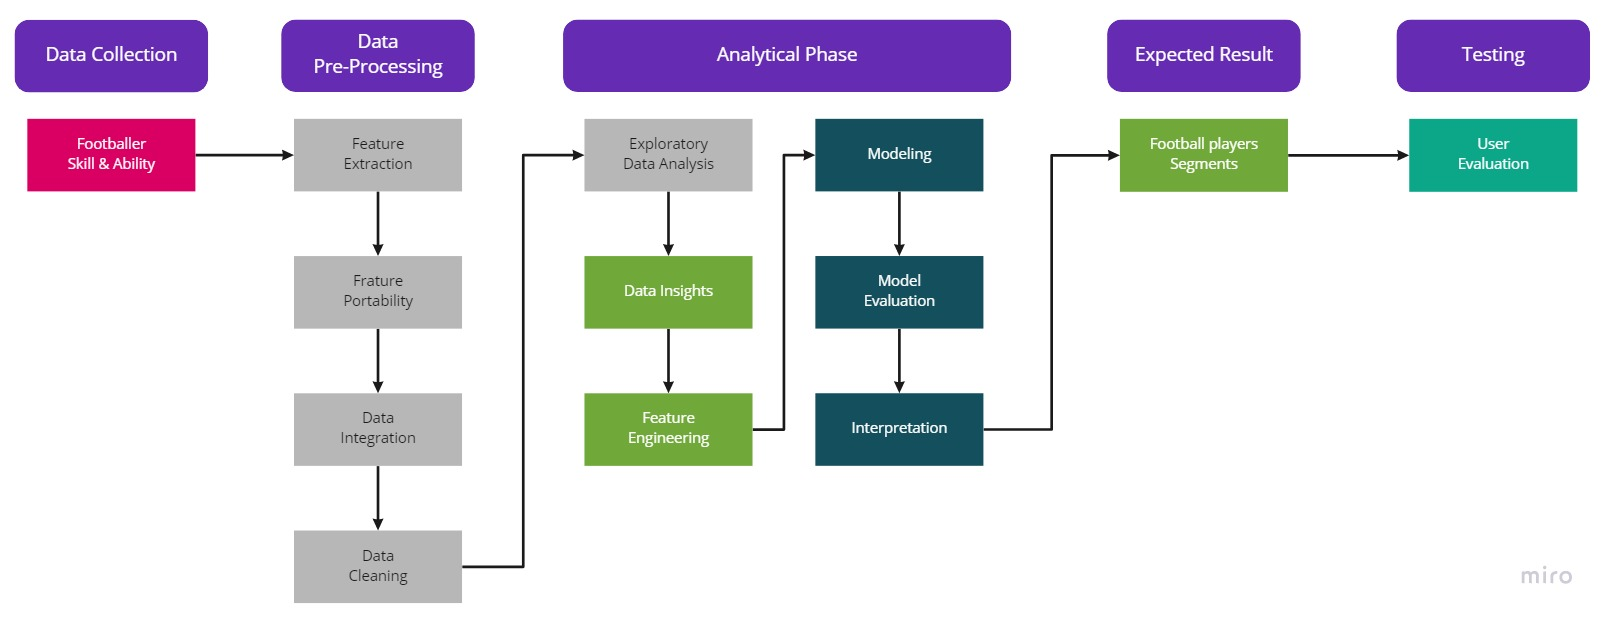

# Importation

In [ ]:
!pip install gradio -q
!pip3 install umap-learn
!pip3 install umap-learn[plot]

In [ ]:
import pandas as pd
import numpy as np
import gradio as gr

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from yellowbrick.cluster import KElbowVisualizer

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import PowerTransformer

import umap
from plotly.subplots import make_subplots
import plotly.graph_objects as go

## Import Dataset

In [ ]:
dataUrl = "https://raw.githubusercontent.com/ZrMuLi/Study_DataMining/main/fifa21_male2.csv"
RawData = pd.read_csv(dataUrl)
RawData

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (78) have mixed types.Specify dtype option on import or set low_memory=False.



ID             Name  Age  OVA  ...   RCB     RB    GK Gender
0           2      G. Pasquale   33   69  ...  69+0  70+-1  17+0   Male
1          16      Luis García   37   71  ...  60+1   60+1  17+1   Male
2          27          J. Cole   33   71  ...  46+0   47+0  15+0   Male
3          36         D. Yorke   36   68  ...  51+0   57+0  22+0   Male
4          41          Iniesta   36   81  ...  64+3   67+3  17+3   Male
...       ...              ...  ...  ...  ...   ...    ...   ...    ...
17120  259088       A. Medioub   22   64  ...  64+2   57+2  12+2   Male
17121  259090       W. Rickard   18   56  ...  49+2   52+2  17+2   Male
17122  259091       C. Barrett   18   56  ...  54+2   54+2  14+2   Male
17123  259101   J. Gazibegović   20   62  ...  58+2   60+2  16+2   Male
17124  259105  Pablo Rodríguez   18   59  ...  30+2   34+2  14+2   Male

[17125 rows x 107 columns]

# Data Preprocessing

## Data Check-Up

In [ ]:
RawData.head(5)

ID         Name  Age  OVA  ...   RCB     RB    GK Gender
0   2  G. Pasquale   33   69  ...  69+0  70+-1  17+0   Male
1  16  Luis García   37   71  ...  60+1   60+1  17+1   Male
2  27      J. Cole   33   71  ...  46+0   47+0  15+0   Male
3  36     D. Yorke   36   68  ...  51+0   57+0  22+0   Male
4  41      Iniesta   36   81  ...  64+3   67+3  17+3   Male

[5 rows x 107 columns]

> คำความเข้าใจกับความหมายในแต่ละ Column
*   OVA => Overall = คะแนนรวม
*   BOV => Best Overall = คะแนนรวมที่ดีที่สุด
*   BP => Best Position = ตำแหน่งที่ดีที่สุด
*   POT => Potential = คะแนนศักยภาพ


> ความหมายในข้อมูลของ Skill & Ability ที่จะเลือกมาใช้
* Long Passing = ส่งไกล
* Finishing = ทำประตูหรือจบสกอร์
* Reactions = ปฏิกิริยาไหวพริบ
* Interceptions = การเข้าสกัดหรือขัดขวาง
* Positioning = การหาช่องว่างเพื่อทำเกม
* Sprint Speed = ความเร็วต้น
* Stamina = ความอึด (เหนื่อยเร็วหรือช้า)

*   อ้างอิง https://sofifa.com/

In [ ]:
RawData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17125 entries, 0 to 17124
Columns: 107 entries, ID to Gender
dtypes: float64(10), int64(45), object(52)
memory usage: 14.0+ MB


**การตรวจสอบข้อมูลว่าง**

In [ ]:
RawData.isna().sum()

ID             0
Name           0
Age            0
OVA            0
Nationality    0
              ..
CB             0
RCB            0
RB             0
GK             0
Gender         0
Length: 107, dtype: int64

In [ ]:
missing = pd.DataFrame()
missing['column'] = RawData.columns

missing['amount'] = [RawData[col].isnull().sum() for col in RawData.columns]

missing = missing[missing['amount']>0].sort_values('amount',ascending=False)

In [ ]:
missing

column  amount
19   Loan Date End   16215
54       Composure     423
8         Position     413
70             D/W      89
69             A/W      89
58  Sliding Tackle      58
52          Vision      58
44         Jumping      58
41         Balance      58
39         Agility      58
32           Curve      58
29         Volleys      58
18          Joined      58
10       Club Logo      23
5             Club      23
50   Interceptions       7
51     Positioning       7

 ### ตรวจสอบประเภทข้อมูล

ในส่วนนี้จะเป็นการตรวจสอบประเภทข้อมูลว่าแต่ละ column นั้นมีข้อมูลประเภทใดบ้าง

In [ ]:
RawData.dtypes

ID              int64
Name           object
Age             int64
OVA             int64
Nationality    object
                ...  
CB             object
RCB            object
RB             object
GK             object
Gender         object
Length: 107, dtype: object

เนื่องจากจำนวนของ Column นั้นมีจำนวนมากจึงนำมาสู่วิธีถัดไป

เพื่อแสดงประเภทของข้อมูลทั้งหมด

In [ ]:
for i in RawData.columns:
  print(i + " : " + str(RawData[i].dtype))

ID : int64
Name : object
Age : int64
OVA : int64
Nationality : object
Club : object
BOV : int64
BP : object
Position : object
Player Photo : object
Club Logo : object
Flag Photo : object
POT : int64
Team & Contract : object
Height : object
Weight : object
foot : object
Growth : int64
Joined : object
Loan Date End : object
Value : object
Wage : object
Release Clause : object
Contract : object
Attacking : int64
Crossing : int64
Finishing : int64
Heading Accuracy : int64
Short Passing : int64
Volleys : float64
Skill : int64
Dribbling : int64
Curve : float64
FK Accuracy : int64
Long Passing : int64
Ball Control : int64
Movement : int64
Acceleration : int64
Sprint Speed : int64
Agility : float64
Reactions : int64
Balance : float64
Power : int64
Shot Power : int64
Jumping : float64
Stamina : int64
Strength : int64
Long Shots : int64
Mentality : int64
Aggression : int64
Interceptions : float64
Positioning : float64
Vision : float64
Penalties : int64
Composure : float64
Defending : int64
Marki

### ตรวจสอบหาค่าว่างในกลุ่มทักษะที่กำหนด

In [ ]:
Skills_Catagory = ["Long Passing","Finishing","Reactions","Interceptions","Positioning","Sprint Speed","Stamina"]

In [ ]:
def CheckNullInSkillsSet():
  print("Null Value in Selected Skills Set")
  for i in Skills_Catagory:
    a = RawData[i].isnull().sum()
    print(f"{i} : {a}")

In [ ]:
CheckNullInSkillsSet()

Null Value in Selected Skills Set
Long Passing : 0
Finishing : 0
Reactions : 0
Interceptions : 7
Positioning : 7
Sprint Speed : 0
Stamina : 0


## Data Cleaning

In [ ]:
# RawData = RawData[RawData[Skills_Catagory].notna()]
RawData = RawData.dropna(subset = Skills_Catagory)
CheckNullInSkillsSet()

Null Value in Selected Skills Set
Long Passing : 0
Finishing : 0
Reactions : 0
Interceptions : 0
Positioning : 0
Sprint Speed : 0
Stamina : 0


In [ ]:
RawData[Skills_Catagory] = RawData[Skills_Catagory].astype(float)
RawData[Skills_Catagory].dtypes

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Long Passing     float64
Finishing        float64
Reactions        float64
Interceptions    float64
Positioning      float64
Sprint Speed     float64
Stamina          float64
dtype: object

# EDA

In [ ]:
RawData[Skills_Catagory].describe()

Long Passing     Finishing  ...  Sprint Speed       Stamina
count  17118.000000  17118.000000  ...  17118.000000  17118.000000
mean      54.324220     47.957530  ...     65.443510     63.310550
std       14.854026     19.388538  ...     14.438118     15.313196
min        9.000000      3.000000  ...     11.000000     11.000000
25%       45.000000     33.000000  ...     59.000000     56.000000
50%       57.000000     52.000000  ...     68.000000     66.000000
75%       65.000000     64.000000  ...     75.000000     73.000000
max       93.000000     95.000000  ...     96.000000     97.000000

[8 rows x 7 columns]

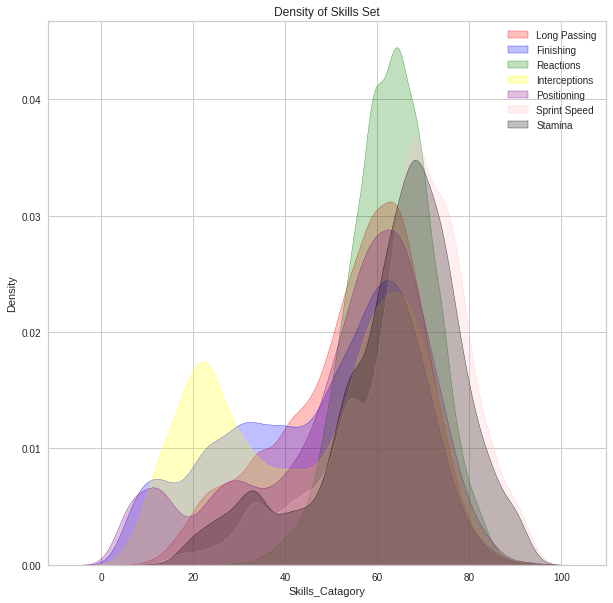

In [ ]:
df = RawData[Skills_Catagory]

# plotting all distributions on the same figure
fig = sns.kdeplot(df["Long Passing"], shade=True, color="red", label="Long Passing")
fig = sns.kdeplot(df['Finishing'], shade=True, color="blue", label="Finishing")
fig = sns.kdeplot(df['Reactions'], shade=True, color="green" ,  label="Reactions")
fig = sns.kdeplot(df['Interceptions'], shade=True, color="yellow",  label="Interceptions")
fig = sns.kdeplot(df['Positioning'], shade=True, color="purple",  label="Positioning")
fig = sns.kdeplot(df['Sprint Speed'], shade=True, color="pink",  label="Sprint Speed")
fig = sns.kdeplot(df['Stamina'], shade=True, color="Black",  label="Stamina")
fig.set_title("Density of Skills Set")
fig.set_xlabel('Skills_Catagory')
plt.legend()
plt.show()

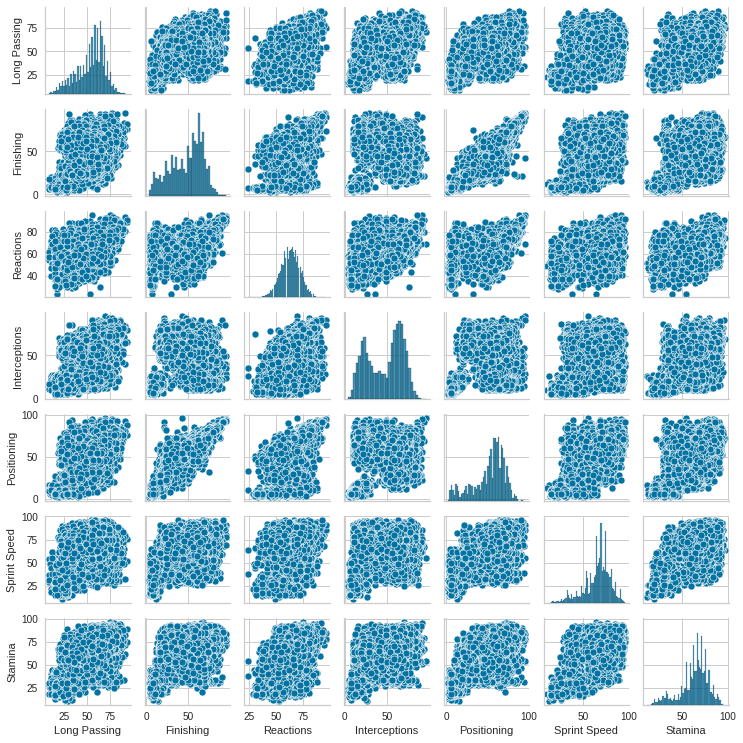

In [ ]:
sns.pairplot(RawData[Skills_Catagory], height=1.5)

## กราฟคะแนน Long Passing 

In [ ]:
pos_cnt=RawData.groupby('BP').apply(lambda x:np.max(x['Long Passing'])).reset_index(name='Long Passing')
pos_cnt.sort_values(by='Long Passing',ascending=False,inplace=True)
top_15_pos_cnt=pos_cnt[:15]
fig=px.bar(top_15_pos_cnt,x='BP',y='Long Passing',color='Long Passing',title='คะแนนของ Long passing ที่ดีที่สุดแต่ละตำแหน่ง',color_continuous_scale="deep")
fig.show()

## กราฟคะแนน Finishing

In [ ]:
pos_cnt=RawData.groupby('BP').apply(lambda x:np.max(x['Finishing'])).reset_index(name='Finishing')
pos_cnt.sort_values(by='Finishing',ascending=False,inplace=True)
top_15_pos_cnt=pos_cnt[:15]
fig=px.bar(top_15_pos_cnt,x='BP',y='Finishing',color='Finishing',title='คะแนนของ Finishing ที่ดีที่สุดในแต่ละตำแหน่ง',color_continuous_scale="deep")
fig.show()

## กราฟคะแนน Interceptions

In [ ]:
pos_cnt=RawData.groupby('BP').apply(lambda x:np.max(x['Interceptions'])).reset_index(name='Interceptions')
pos_cnt.sort_values(by='Interceptions',ascending=False,inplace=True)
top_15_pos_cnt=pos_cnt[:15]
fig=px.bar(top_15_pos_cnt,x='BP',y='Interceptions',color='Interceptions',title='คะแนนของ Interceptions ที่ดีที่สุดในแต่ละตำแหน่ง',color_continuous_scale="deep")
fig.show()

## กราฟคะแนน Positioning

In [ ]:
pos_cnt=RawData.groupby('BP').apply(lambda x:np.max(x['Positioning'])).reset_index(name='Positioning')
pos_cnt.sort_values(by='Positioning',ascending=False,inplace=True)
top_15_pos_cnt=pos_cnt[:15]
fig=px.bar(top_15_pos_cnt,x='BP',y='Positioning',color='Positioning',title='คะแนนของ Positioning ที่ดีที่สุดในแต่ละตำแหน่ง',color_continuous_scale="deep")
fig.show()

## กราฟคะแนน Sprint Speed

In [ ]:
pos_cnt=RawData.groupby('BP').apply(lambda x:np.max(x['Sprint Speed'])).reset_index(name='Sprint Speed')
pos_cnt.sort_values(by='Sprint Speed',ascending=False,inplace=True)
top_15_pos_cnt=pos_cnt[:15]
fig=px.bar(top_15_pos_cnt,x='BP',y='Sprint Speed',color='Sprint Speed',title='คะแนนของ Sprint Speed ที่ดีที่สุดในแต่ละตำแหน่ง',color_continuous_scale="deep")
fig.show()

## กราฟคะแนน Stamina

In [ ]:
pos_cnt=RawData.groupby('BP').apply(lambda x:np.max(x['Stamina'])).reset_index(name='Stamina')
pos_cnt.sort_values(by='Stamina',ascending=False,inplace=True)
top_15_pos_cnt=pos_cnt[:15]
fig=px.bar(top_15_pos_cnt,x='BP',y='Stamina',color='Stamina',title='คะแนนของ Stamina ที่ดีที่สุดในแต่ละตำแหน่ง',color_continuous_scale="deep")
fig.show()

## กราฟคะแนน Reactions

In [ ]:
pos_cnt=RawData.groupby('BP').apply(lambda x:np.max(x['Reactions'])).reset_index(name='Reactions')
pos_cnt.sort_values(by='Reactions',ascending=False,inplace=True)
top_15_pos_cnt=pos_cnt[:15]
fig=px.bar(top_15_pos_cnt,x='BP',y='Reactions',color='Reactions',title='คะแนนของ Reactions ที่ดีที่สุดในแต่ละตำแหน่ง',color_continuous_scale="deep")
fig.show()

# Feature Engineering

In [ ]:
RawFeatureData = RawData[Skills_Catagory]
RawFeatureData

Long Passing  Finishing  Reactions  ...  Positioning  Sprint Speed  Stamina
0              69.0       50.0       69.0  ...         63.0          74.0     69.0
1              71.0       64.0       65.0  ...         72.0          50.0     64.0
2              69.0       64.0       59.0  ...         69.0          42.0     29.0
3              64.0       70.0       55.0  ...         72.0          62.0     51.0
4              83.0       69.0       75.0  ...         78.0          56.0     58.0
...             ...        ...        ...  ...          ...           ...      ...
17120          34.0       23.0       48.0  ...         23.0          55.0     59.0
17121          61.0       43.0       54.0  ...         55.0          63.0     53.0
17122          36.0       34.0       59.0  ...         49.0          61.0     53.0
17123          57.0       26.0       56.0  ...         46.0          70.0     57.0
17124          30.0       64.0       53.0  ...         64.0          72.0     55.0

[17118 rows x 7 columns]

In [ ]:
featureData2Condition = Skills_Catagory.copy()
featureData2Condition.remove("Reactions")
RawFeatureData2 = RawData[featureData2Condition]
RawFeatureData2

Long Passing  Finishing  ...  Sprint Speed  Stamina
0              69.0       50.0  ...          74.0     69.0
1              71.0       64.0  ...          50.0     64.0
2              69.0       64.0  ...          42.0     29.0
3              64.0       70.0  ...          62.0     51.0
4              83.0       69.0  ...          56.0     58.0
...             ...        ...  ...           ...      ...
17120          34.0       23.0  ...          55.0     59.0
17121          61.0       43.0  ...          63.0     53.0
17122          36.0       34.0  ...          61.0     53.0
17123          57.0       26.0  ...          70.0     57.0
17124          30.0       64.0  ...          72.0     55.0

[17118 rows x 6 columns]

### Feature 1

In [ ]:
# for Box-Cox Transformation
boxcox = PowerTransformer(method='box-cox')
# normalize the exponential data with boxcox
FeatureData = boxcox.fit_transform(RawFeatureData)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



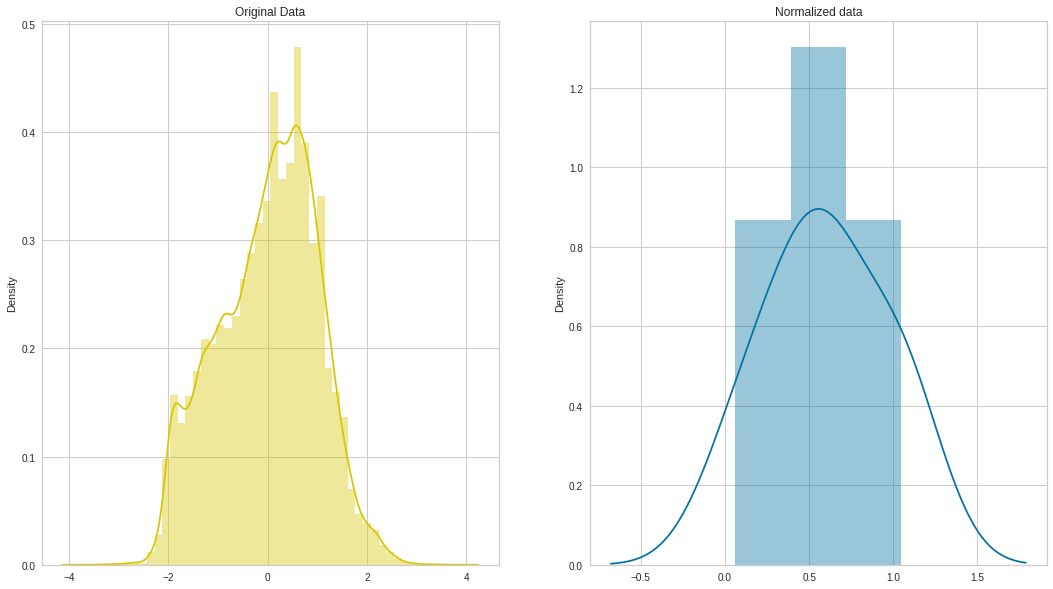

In [ ]:
#plot both together to compare
fig, ax=plt.subplots(1,2)
fig.set_size_inches(18,10)
sns.distplot(FeatureData, ax=ax[0], color='y')
ax[0].set_title("Original Data")
sns.distplot(FeatureData[0], ax=ax[1])
ax[1].set_title("Normalized data")
plt.show()

### Feature 2

In [ ]:
# for Box-Cox Transformation
boxcox = PowerTransformer(method='box-cox')
# normalize the exponential data with boxcox
FeatureData2 = boxcox.fit_transform(RawFeatureData2)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



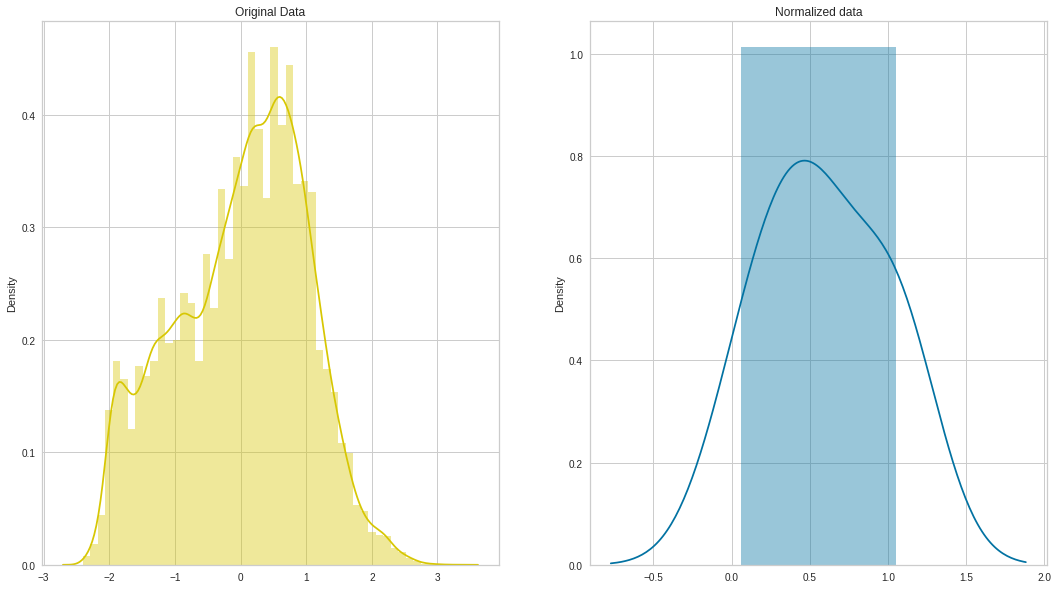

In [ ]:
#plot both together to compare
fig, ax=plt.subplots(1,2)
fig.set_size_inches(18,10)
sns.distplot(FeatureData2, ax=ax[0], color='y')
ax[0].set_title("Original Data")
sns.distplot(FeatureData2[0], ax=ax[1])
ax[1].set_title("Normalized data")
plt.show()

# Kmeans Model

**Parameter**
พื้นที่สำหรับสร้างตัวแปรเพื่อใช้งานหลังจากนี้

In [ ]:
#Create paragrams for convenient use 
r_state = 4
from_K = 2
to_K = 7

# Modeling

## Model 1

## Evaluation

In [ ]:
def elbow_plot(X, from_k, to_k):
  """
  Evaluate the number of clusters
  """
  ssd=[]
  for k in range(from_k, to_k+1):
    model = KMeans(n_clusters=k)
    model.fit(X)
    ssd.append([k, model.inertia_])
  # # create dataframe from k amount
  # dd=pd.DataFrame(ssd, columns=['k', 'ssd'])
  # # create a pch_chg column
  # dd['pct_chg'] = dd['ssd'].pct_change().fillna(0)*100
  # # line plot with (x=k, y=inertia)
  # plt.plot(dd['k'], dd['ssd'], linestyle='--', marker='o')

  # # annotation
  # for index, row in dd.iterrows():
  #   plt.text(row['k']+.15, row['ssd']+1.5, "{:.2f}".format(row['pct_chg']), fontsize=12)


In [ ]:
elbow_plot(FeatureData,from_K,to_K)

In [ ]:
#create array to be using
wss = []
sil = []
k_Cluster_List = []
#loop for cluster by specific group amuont 
k = range(from_K, to_K)
for n in k:

    # initialize clustering model
    algorithm = (KMeans(n_clusters = n,random_state=r_state) )
    algorithm.fit(FeatureData)
    labels = algorithm.labels_
    cluster_k = f'k_m1_{n}'
    RawData[cluster_k] = labels
    k_Cluster_List.append(cluster_k)

    # assign Weight of sum squared distance & silhouette score to specific array
    wss.append(algorithm.inertia_)
    sil.append(silhouette_score(FeatureData, labels, metric = 'euclidean'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

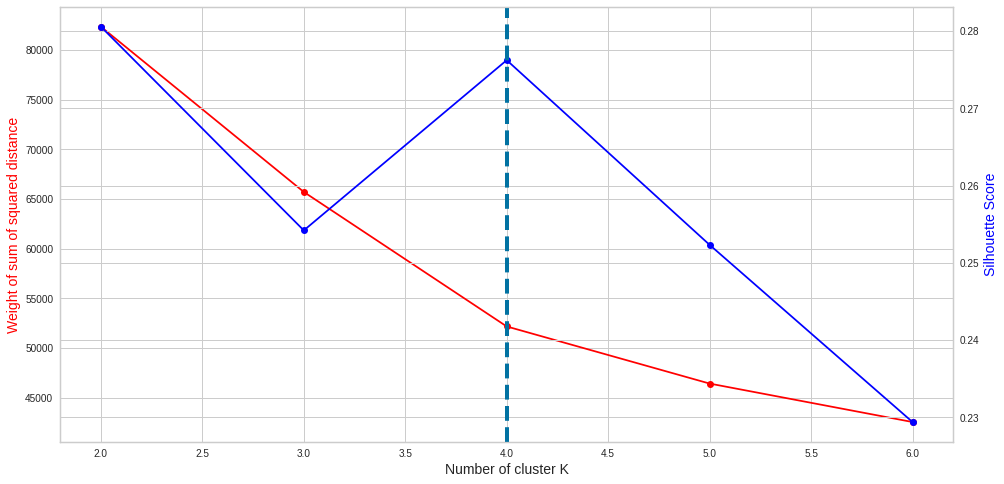

In [ ]:
#plot graph first
fig,ax = plt.subplots()
fig.set_size_inches(16,8)
ax.plot(k, wss, color="red", marker="o")
ax.set_xlabel("Number of cluster K",fontsize=14)
ax.set_ylabel("Weight of sum of squared distance",color="red",fontsize=14)

ax2=ax.twinx()
ax2.plot(k, sil,color="blue",marker="o")
ax2.set_ylabel("Silhouette Score",color="blue",fontsize=14)
#after we saw the graph

#then we draw a line 
plt.axvline(4, lw=4, linestyle='--')
plt.show()

## Interpretation

In [ ]:
#Parameter for using to show specific
InterPretShowData = ["Name"]
InterPretShowData.extend(Skills_Catagory)
InterPretShowData.extend(k_Cluster_List)

#Show specific data
RawData[InterPretShowData]

Name  Long Passing  Finishing  ...  k_m1_4  k_m1_5  k_m1_6
0          G. Pasquale          69.0       50.0  ...       3       4       0
1          Luis García          71.0       64.0  ...       3       4       5
2              J. Cole          69.0       64.0  ...       2       0       4
3             D. Yorke          64.0       70.0  ...       2       4       0
4              Iniesta          83.0       69.0  ...       3       4       5
...                ...           ...        ...  ...     ...     ...     ...
17120       A. Medioub          34.0       23.0  ...       1       3       1
17121       W. Rickard          61.0       43.0  ...       1       3       1
17122       C. Barrett          36.0       34.0  ...       1       3       1
17123   J. Gazibegović          57.0       26.0  ...       1       3       1
17124  Pablo Rodríguez          30.0       64.0  ...       2       0       4

[17118 rows x 13 columns]

### Box-Cox


#### K = 3

In [ ]:
model = KMeans(n_clusters=3,random_state=r_state)
model.fit(FeatureData)
model.cluster_centers_.round(4)

array([[ 0.7317,  0.0639,  0.4689,  0.8455,  0.2489,  0.0986,  0.6451],
       [-1.0412, -1.3152, -0.5829, -0.3079, -1.3628, -0.9841, -1.0078],
       [-0.2081,  0.7889, -0.1889, -0.8307,  0.5942,  0.5283, -0.1243]])

In [ ]:
RawData.groupby('k_m1_3')[Skills_Catagory].mean()

Long Passing  Finishing  ...  Sprint Speed    Stamina
k_m1_3                           ...                         
0          64.863255  49.599670  ...     67.419865  72.696657
1          38.129890  21.908719  ...     50.568653  46.878803
2          52.089087  63.104075  ...     72.821320  62.643146

[3 rows x 7 columns]

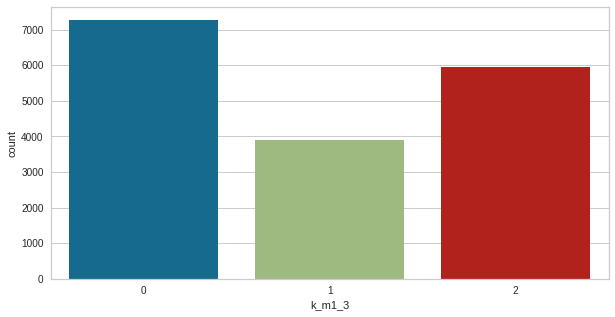

In [ ]:
fig = plt.figure(figsize=(10,5))
sns.countplot(x='k_m1_3', data=RawData);

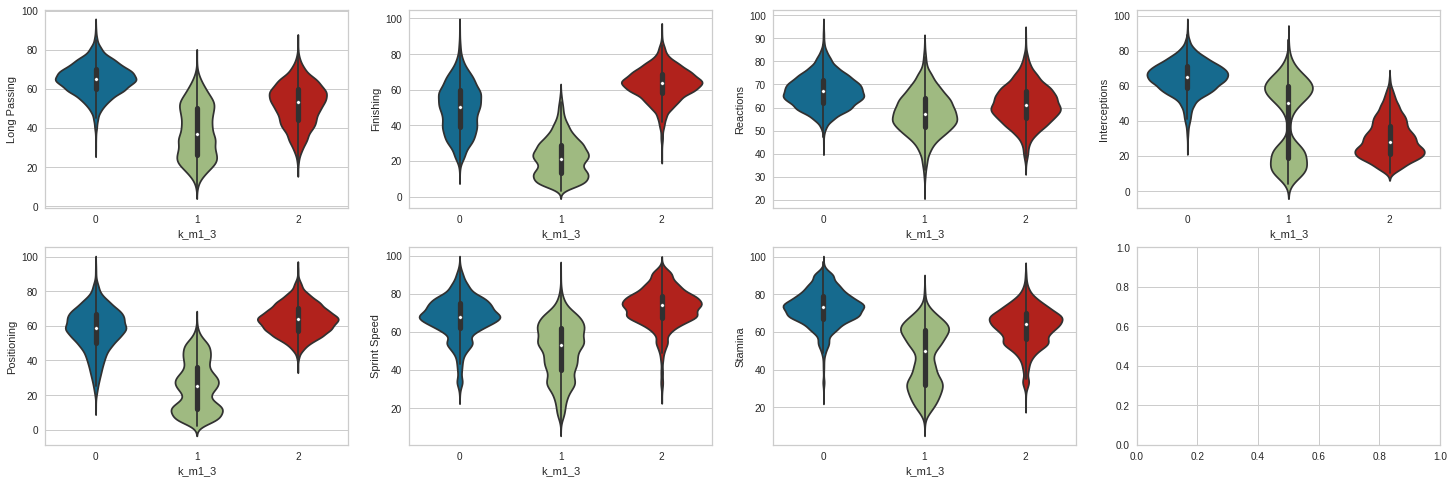

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(25,8))
ax = ax.ravel()
for pos, col in enumerate(Skills_Catagory):
  sns.violinplot(x='k_m1_3', y=col, data=RawData, ax=ax[pos])

#### K = 4

In [ ]:
model = KMeans(n_clusters=4,random_state=r_state)
model.fit(FeatureData)
model.cluster_centers_.round(4)

array([[-1.6539, -1.7603, -0.2348, -1.4243, -1.8798, -1.6324, -1.8219],
       [-0.0989, -0.735 , -0.422 ,  0.6658, -0.6407, -0.293 , -0.0347],
       [-0.343 ,  0.7555, -0.3586, -0.9364,  0.5113,  0.4844, -0.2241],
       [ 0.9501,  0.5668,  0.8534,  0.6726,  0.7448,  0.3381,  0.8213]])

In [ ]:
RawData.groupby('k_m1_4')[Skills_Catagory].mean()

Long Passing  Finishing  ...  Sprint Speed    Stamina
k_m1_4                           ...                         
0          26.944238  11.927509  ...     38.597274  30.719331
1          53.629651  34.324268  ...     62.228895  63.963551
2          50.136318  62.522388  ...     72.293333  61.202587
3          67.617670  58.982253  ...     70.445602  74.833912

[4 rows x 7 columns]

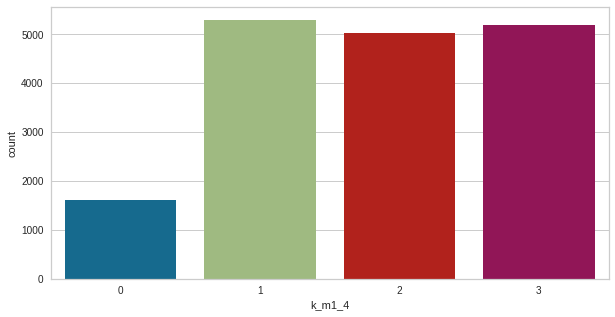

In [ ]:
fig = plt.figure(figsize=(10,5))
sns.countplot(x='k_m1_4', data=RawData);

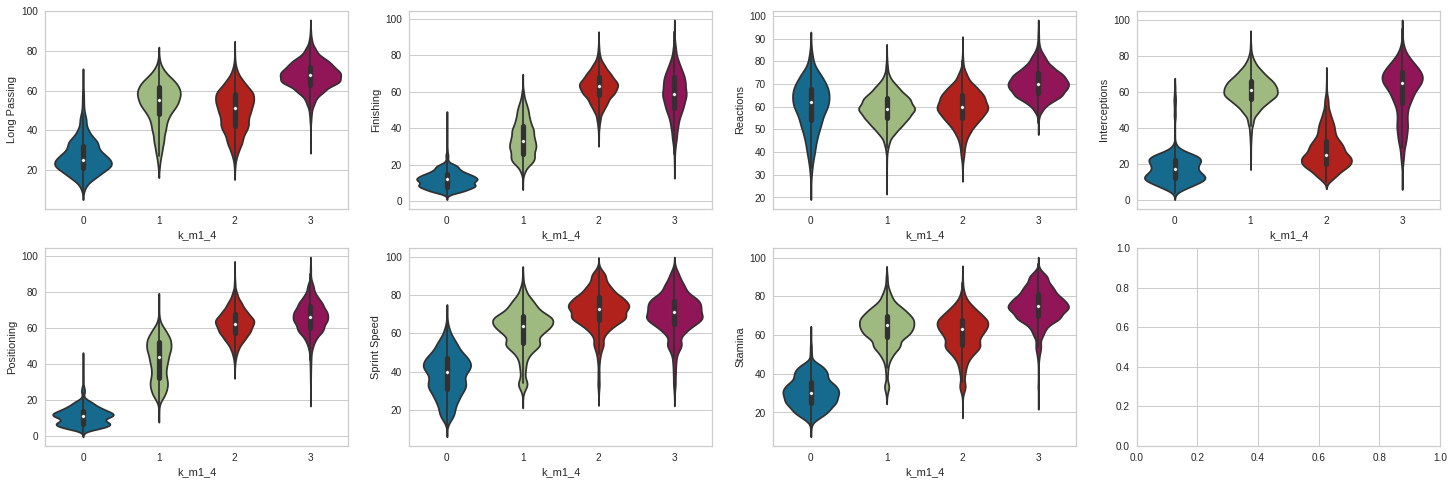

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(25,8))
ax = ax.ravel()
for pos, col in enumerate(Skills_Catagory):
  sns.violinplot(x='k_m1_4', y=col, data=RawData, ax=ax[pos])

#### K = 5

In [ ]:
model = KMeans(n_clusters=5,random_state=r_state)
model.fit(FeatureData)
model.cluster_centers_.round(4)

array([[-0.4758,  0.5539, -0.7993, -0.9508,  0.2538,  0.3578, -0.428 ],
       [ 0.2907,  1.1754,  0.759 , -0.6214,  1.1178,  0.7418,  0.3399],
       [-1.6567, -1.7655, -0.2224, -1.4372, -1.885 , -1.6386, -1.8285],
       [-0.1877, -0.814 , -0.4624,  0.666 , -0.7232, -0.3306, -0.0908],
       [ 0.9481,  0.2718,  0.6769,  0.9515,  0.4882,  0.1654,  0.8441]])

In [ ]:
RawData.groupby('k_m1_5')[Skills_Catagory].mean()

Long Passing  Finishing  ...  Sprint Speed    Stamina
k_m1_5                           ...                         
0          48.192768  58.936503  ...     70.890376  58.281891
1          59.067672  69.952665  ...     75.195652  69.009116
2          26.882427  11.809256  ...     38.470919  30.567855
3          52.357237  32.755356  ...     61.704854  63.249453
4          67.614276  53.643528  ...     68.344030  75.107837

[5 rows x 7 columns]

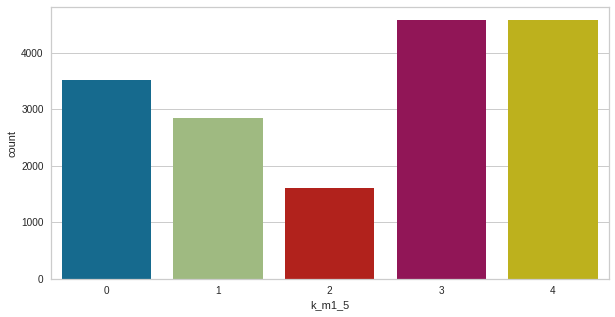

In [ ]:
fig = plt.figure(figsize=(10,5))
sns.countplot(x='k_m1_5', data=RawData);

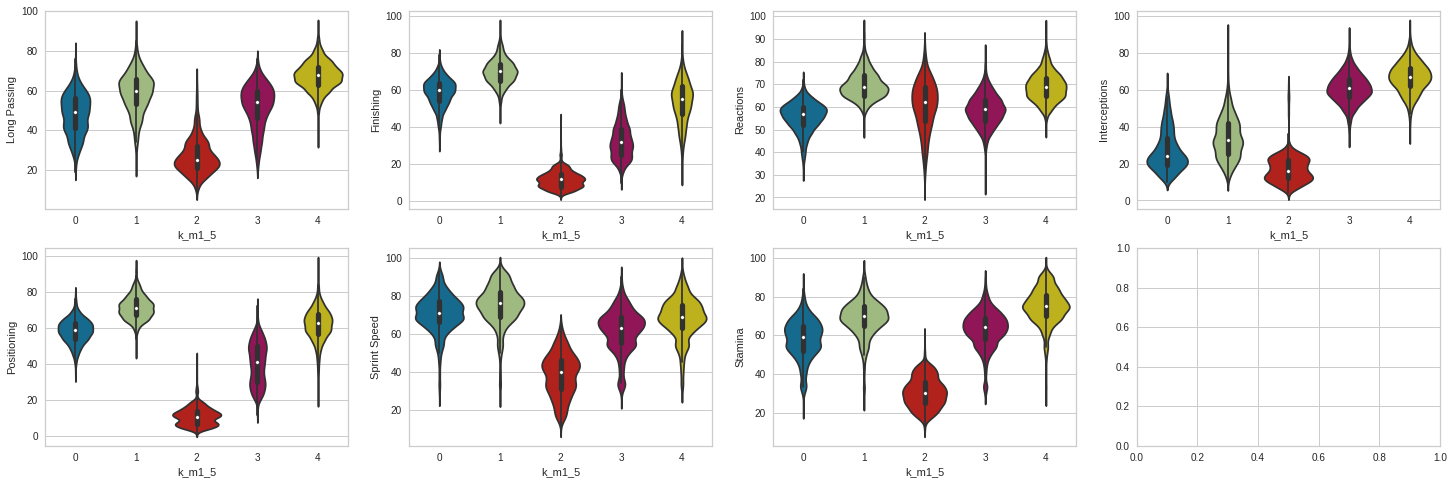

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(25,8))
ax = ax.ravel()
for pos, col in enumerate(Skills_Catagory):
  sns.violinplot(x='k_m1_5', y=col, data=RawData, ax=ax[pos])

## Model 2 

## Evaluation

In [ ]:
Skills_Catagory2 = Skills_Catagory.copy()
Skills_Catagory2.remove("Reactions")

In [ ]:
elbow_plot(FeatureData2,from_K,to_K)

In [ ]:
#create array to be using
wss2 = []
sil2 = []
k_Cluster_List = []
#loop for cluster by specific group amuont 
k = range(from_K, to_K)
for n in k:

    # initialize clustering model
    algorithm = (KMeans(n_clusters = n,random_state=r_state) )
    algorithm.fit(FeatureData2)
    labels = algorithm.labels_
    cluster_k = f'k_m2_{n}'
    RawData[cluster_k] = labels
    k_Cluster_List.append(cluster_k)

    # assign Weight of sum squared distance & silhouette score to specific array
    wss2.append(algorithm.inertia_)
    sil2.append(silhouette_score(FeatureData2, labels, metric = 'euclidean'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

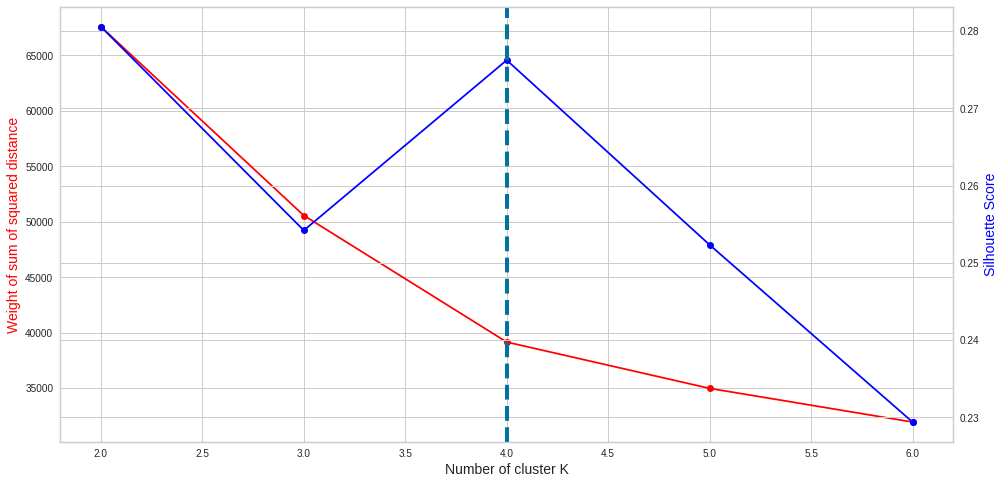

In [ ]:
#plot graph first
fig,ax = plt.subplots()
fig.set_size_inches(16,8)
ax.plot(k, wss2, color="red", marker="o")
ax.set_xlabel("Number of cluster K",fontsize=14)
ax.set_ylabel("Weight of sum of squared distance",color="red",fontsize=14)

ax2=ax.twinx()
ax2.plot(k, sil,color="blue",marker="o")
ax2.set_ylabel("Silhouette Score",color="blue",fontsize=14)
#after we saw the graph

#then we draw a line 
plt.axvline(4, lw=4, linestyle='--')
plt.show()

## Interpretation

In [ ]:
#Parameter for using to show specific
InterPretShowData = ["Name"]
InterPretShowData.extend(Skills_Catagory)
InterPretShowData.extend(k_Cluster_List)

#Show specific data
RawData[InterPretShowData]

Name  Long Passing  Finishing  ...  k_m2_4  k_m2_5  k_m2_6
0          G. Pasquale          69.0       50.0  ...       1       4       4
1          Luis García          71.0       64.0  ...       1       4       5
2              J. Cole          69.0       64.0  ...       2       0       5
3             D. Yorke          64.0       70.0  ...       1       4       5
4              Iniesta          83.0       69.0  ...       1       4       5
...                ...           ...        ...  ...     ...     ...     ...
17120       A. Medioub          34.0       23.0  ...       3       3       0
17121       W. Rickard          61.0       43.0  ...       3       3       5
17122       C. Barrett          36.0       34.0  ...       3       3       0
17123   J. Gazibegović          57.0       26.0  ...       3       3       0
17124  Pablo Rodríguez          30.0       64.0  ...       2       0       2

[17118 rows x 13 columns]

## Box-Cox

### K = 3

In [ ]:
model = KMeans(n_clusters=3,random_state=r_state)
model.fit(FeatureData2)
model.cluster_centers_.round(4)

array([[-0.1421,  0.8631, -0.8349,  0.6699,  0.544 , -0.0785],
       [ 0.5771, -0.1108,  0.8323,  0.0653,  0.0324,  0.5233],
       [-1.2734, -1.4549, -0.5556, -1.5389, -1.1937, -1.257 ]])

In [ ]:
RawData.groupby('k_m2_3')[Skills_Catagory2].mean()

Long Passing  Finishing  ...  Sprint Speed    Stamina
k_m2_3                           ...                         
0          52.896404  64.409601  ...     72.977565  63.173540
1          62.827194  46.316564  ...     66.604821  71.154388
2          34.049899  18.808159  ...     46.877613  42.195887

[3 rows x 6 columns]

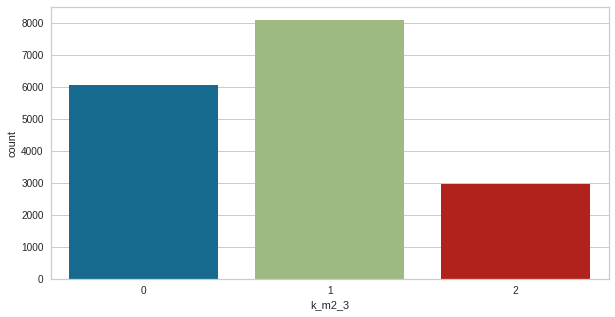

In [ ]:
fig = plt.figure(figsize=(10,5))
sns.countplot(x='k_m2_3', data=RawData);

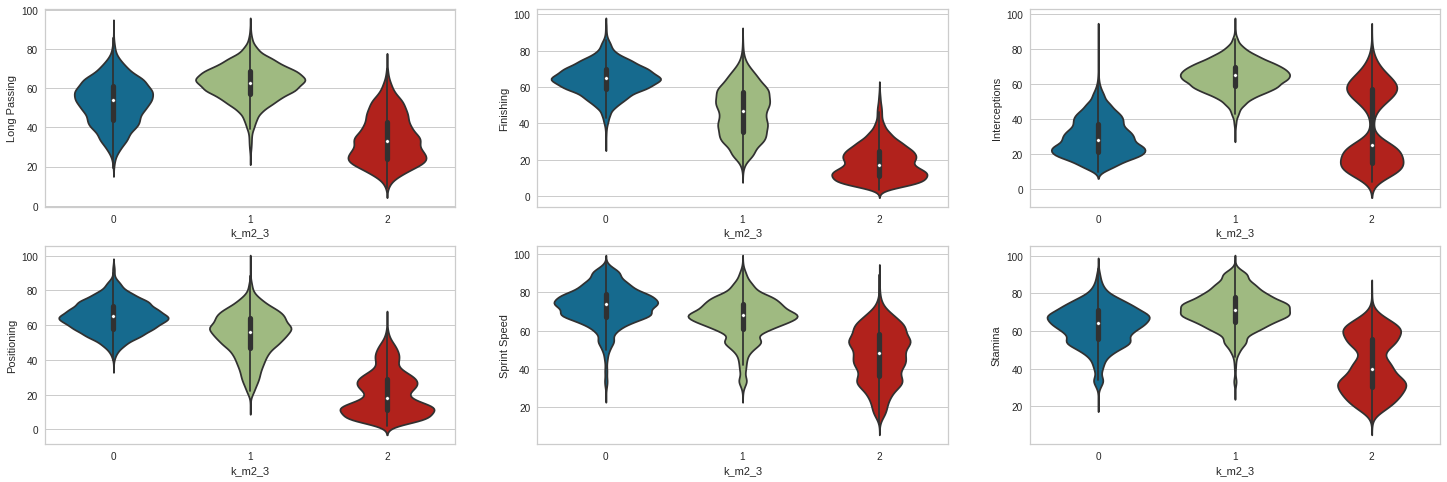

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25,8))
ax = ax.ravel()
for pos, col in enumerate(Skills_Catagory2):
  sns.violinplot(x='k_m2_3', y=col, data=RawData, ax=ax[pos])

### K = 4

In [ ]:
model = KMeans(n_clusters=4,random_state=r_state)
model.fit(FeatureData2)
model.cluster_centers_.round(4)

array([[-1.6533, -1.7574, -1.4246, -1.8775, -1.6297, -1.8211],
       [ 0.9187,  0.4186,  0.7799,  0.6139,  0.309 ,  0.8658],
       [-0.2564,  0.8282, -0.9196,  0.6108,  0.5039, -0.1757],
       [-0.128 , -0.7872,  0.6864, -0.708 , -0.3506, -0.1077]])

In [ ]:
RawData.groupby('k_m2_4')[Skills_Catagory2].mean()

Long Passing  Finishing  ...  Sprint Speed    Stamina
k_m2_4                           ...                         
0          26.956710  11.988250  ...     38.651206  30.739641
1          67.240101  56.329237  ...     70.174761  75.410571
2          51.344570  63.795554  ...     72.496538  61.881560
3          53.175194  33.287352  ...     61.423659  62.997953

[4 rows x 6 columns]

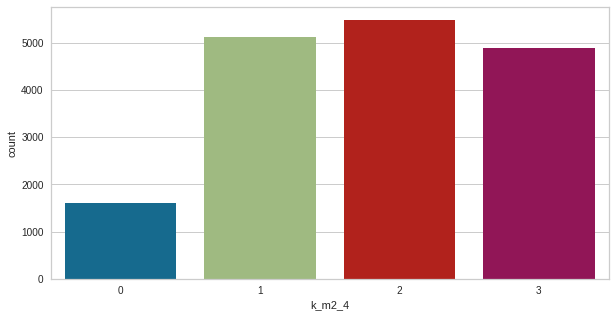

In [ ]:
fig = plt.figure(figsize=(10,5))
sns.countplot(x='k_m2_4', data=RawData);

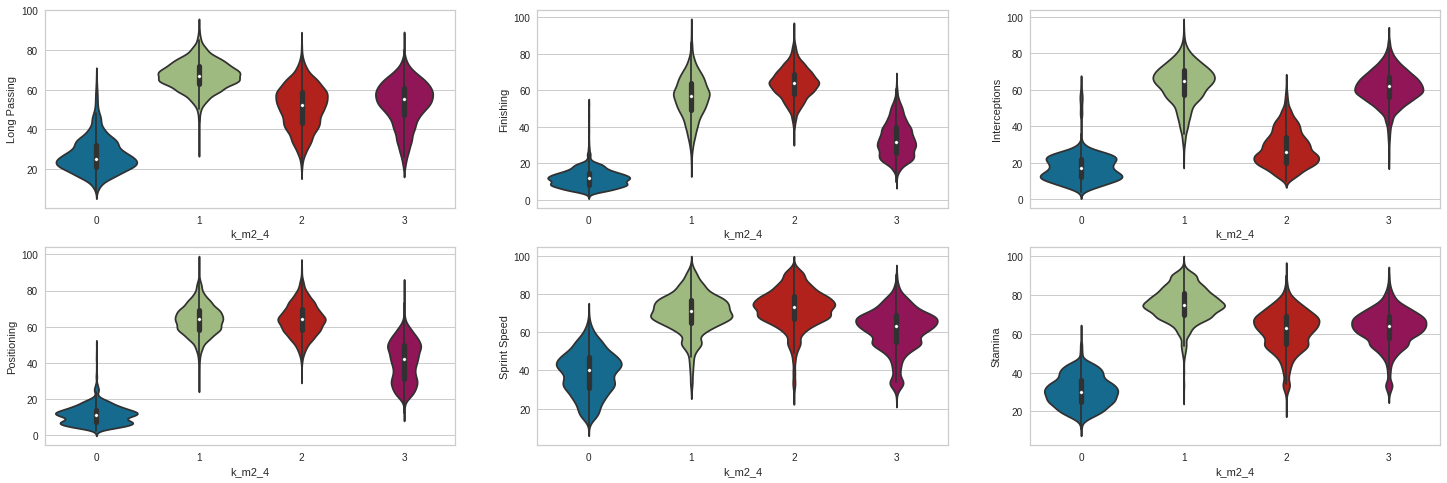

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25,8))
ax = ax.ravel()
for pos, col in enumerate(Skills_Catagory2):
  sns.violinplot(x='k_m2_4', y=col, data=RawData, ax=ax[pos])

### K = 5

In [ ]:
model = KMeans(n_clusters=5,random_state=r_state)
model.fit(FeatureData2)
model.cluster_centers_.round(4)

array([[-0.5242,  0.6465, -1.0233,  0.3561,  0.1001, -0.5701],
       [ 0.248 ,  1.0355, -0.5907,  0.9483,  1.0334,  0.439 ],
       [-1.6555, -1.7637, -1.4293, -1.8827, -1.6364, -1.8244],
       [-0.1964, -0.8426,  0.6966, -0.7651, -0.3509, -0.1222],
       [ 0.9242,  0.2799,  0.8881,  0.4962,  0.1483,  0.8216]])

In [ ]:
RawData.groupby('k_m2_5')[Skills_Catagory2].mean()

Long Passing  Finishing  ...  Sprint Speed    Stamina
k_m2_5                           ...                         
0          47.385072  60.560587  ...     67.684260  56.149906
1          58.598358  67.500821  ...     78.752709  70.466667
2          26.907903  11.851898  ...     38.522091  30.658992
3          52.195348  32.163279  ...     61.378500  62.821590
4          67.287221  53.766956  ...     68.247725  74.843672

[5 rows x 6 columns]

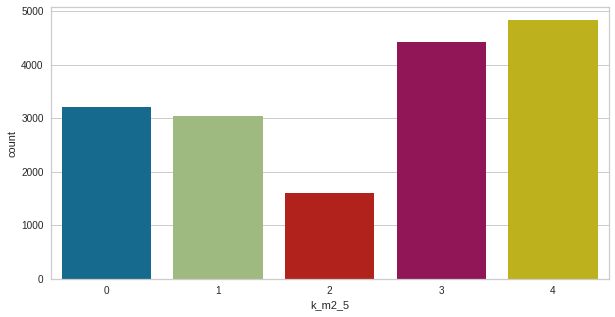

In [ ]:
fig = plt.figure(figsize=(10,5))
sns.countplot(x='k_m2_5', data=RawData);

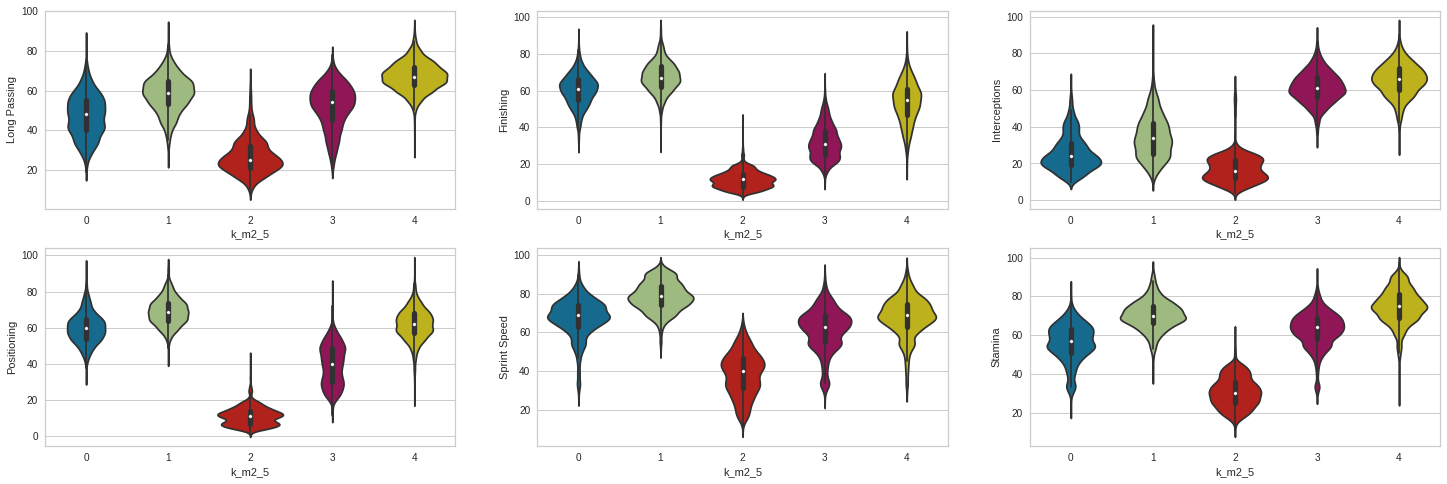

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25,8))
ax = ax.ravel()
for pos, col in enumerate(Skills_Catagory2):
  sns.violinplot(x='k_m2_5', y=col, data=RawData, ax=ax[pos])

## Visualizing 3D Model 1 & 2

In [ ]:
def color_change_3d(data,col,round):
  Colors = ['blue','orange','green','red','purple',"pink"]
  dic = {}
  for i in range(0, round):
    dic[i] = Colors[i]

  return data[col].map(dic)

In [ ]:
features = RawData[Skills_Catagory]
umap_3d = umap.UMAP(n_components=3, init='random', random_state=r_state)
proj_3d = umap_3d.fit_transform(features)

In [ ]:
fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=("Model 1 k = 3", "Model 1  k = 4", "Model 1 k = 5", "Model 2 k = 3", "Model 2  k = 4", "Model 2 k = 5"),
    specs=[[{"type": "scatter3d"}, {"type": "scatter3d"}, {"type": "scatter3d"}], [{"type": "scatter3d"}, {"type": "scatter3d"}, {"type": "scatter3d"}]])

fig.add_trace(go.Scatter3d(x=proj_3d[:,0], 
                           y=proj_3d[:,1], 
                           z=proj_3d[:,2], 
                           mode="markers",
                           marker=dict(color=color_change_3d(RawData,'k_m1_3',3),size=5,showscale=False)),
                           row=1, col=1)

fig.add_trace(go.Scatter3d(x=proj_3d[:,0], 
                           y=proj_3d[:,1],
                           z=proj_3d[:,2], 
                           mode="markers",
                           marker=dict(color=color_change_3d(RawData,'k_m1_4',4),size=5,showscale=False)),
                           row=1, col=2)

fig.add_trace(go.Scatter3d(x=proj_3d[:,0], 
                           y=proj_3d[:,1],
                           z=proj_3d[:,2], 
                           mode="markers",
                           marker=dict(color=color_change_3d(RawData,'k_m1_5',5),size=5,showscale=False)),
                           row=1, col=3)

fig.add_trace(go.Scatter3d(x=proj_3d[:,0], 
                           y=proj_3d[:,1], 
                           z=proj_3d[:,2], 
                           mode="markers",
                           marker=dict(color=color_change_3d(RawData,'k_m2_3',3),size=5,showscale=False)),
                           row=2, col=1)

fig.add_trace(go.Scatter3d(x=proj_3d[:,0], 
                           y=proj_3d[:,1],
                           z=proj_3d[:,2], 
                           mode="markers",
                           marker=dict(color=color_change_3d(RawData,'k_m2_4',4),size=5,showscale=False)),
                           row=2, col=2)

fig.add_trace(go.Scatter3d(x=proj_3d[:,0], 
                           y=proj_3d[:,1],
                           z=proj_3d[:,2], 
                           mode="markers",
                           marker=dict(color=color_change_3d(RawData,'k_m2_5',5),size=5,showscale=False)),
                           row=2, col=3)

fig.update_layout(height=700,title_text="Visualizing 3D Modeling", showlegend=False)
fig.show()

# ผลจากการทดสอบ
*   ผลจากการทดสอบทั้ง 2 Model ในช่วงของ Evaluate จำนวน K ที่เราเห็นและน่าใช้มากที่สุดคือ K = 4 เพราะ มีความแตกต่างมากที่สุด
*   ผลจากการทดสอบ Interpretation โดยใช้ Violin Plot เป็นตัวแสดงผลการทดสอบ K ที่ 3, 4 และ 5 ทำให้เราเห็นความแตกต่างจากการแบ่งกลุ่มในแต่ละ K ได้ชัดมาก

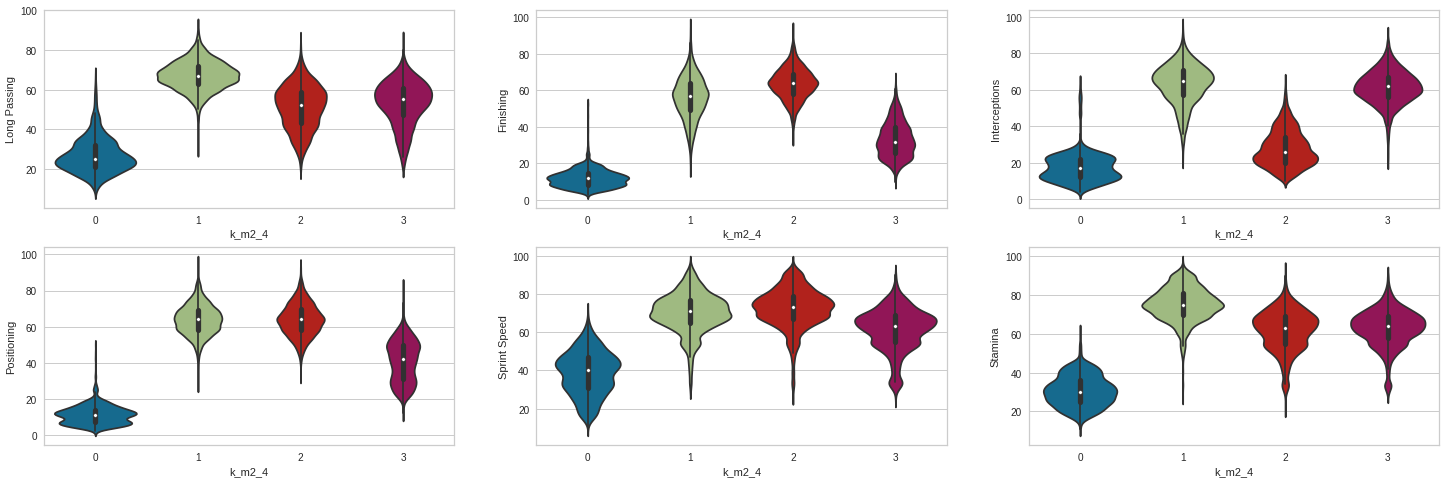
  > **ความหมายในแต่ละกลุ่ม**
*   **กลุ่มที่ 0 คือ ด่านสุดท้าย (ผู้รักษาประตู)**
  * ส่งไกลปานกลาง จบสกอลไม่เป็น สกัดกั้นไม่เป็น หาช่องว่างในการเล่นได้ไม่ดี ความเร็วต่ำ เหนื่อยง่าย
*   **กลุ่มที่ 1 คือ ตัวทำเกม + ตัวป่วน (ปีก + กองกลางตัวรุก + กลางรับ)**
  * ส่งไกลได้ดี จบสกอลเป็น สกัดกั้นเป็น หาช่องว่างได้ดีรู้หน้าที่ มีความเร็ว ไม่รู้เหนื่อย
*   **กลุ่มที่ 2 คือ ตัวทำประตู (กองหน้า กองกลางตัวรุก)**
  * ส่งไกลได้ดี จบสกอลได้ดี หาช่องว่างได้ดี ความเร็วเป็นเลิศ ไม่เหนื่อยง่าย แต่สกัดกั้นไม่เป็น
*   **กลุ่มที่ 3 คือ กำแพงตัวสกัดกั้น (กองหลัง)**
  * ส่งไกลได้ดี สกัดกั้นได้ดี ความเร็วพอได้ ไม่เหนื่อยง่าย การหาตำแหน่งพอใช้ได้ แต่จบสกอลไม่เป็น

# Pipeline

In [ ]:
class Pipeline:
    def __init__(self,data,Skills_Catagory):

        self.transformer = PowerTransformer(method='box-cox')

        self.Skills_Catagory = Skills_Catagory

        #Drop NaN in selected skills set
        data = data.dropna(subset = self.Skills_Catagory)

        #Change selected data type to float
        data[self.Skills_Catagory] = data[self.Skills_Catagory].astype(float)

        #Filter only selected skills set
        self.data = data[self.Skills_Catagory]

    def train(self,data):
        result = self.transformer.fit_transform(data[self.Skills_Catagory])
        return result

    def predict(self,data):
        result = self.transformer.transform(data[self.Skills_Catagory])
        return result


In [ ]:
getData = pd.read_csv(dataUrl)
skills = ["Long Passing","Finishing","Interceptions","Positioning","Sprint Speed","Stamina"]
pipeline = Pipeline(getData,skills)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (78) have mixed types.Specify dtype option on import or set low_memory=False.

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
tfData = pipeline.train(pipeline.data)
tfData

array([[ 1.04344866,  0.0609304 ,  1.04825776,  0.530171  ,  0.56255669,
         0.28926906],
       [ 1.21470039,  0.83282112,  1.14273597,  1.1387157 , -1.15402464,
        -0.09012025],
       [ 1.04344866,  0.83282112, -0.38022061,  0.93069121, -1.56075787,
        -1.91326672],
       ...,
       [-1.25535324, -0.76649899,  0.38452873, -0.3195571 , -0.46115263,
        -0.819233  ],
       [ 0.08981046, -1.15247293,  0.52713278, -0.48527607,  0.22358046,
        -0.57083094],
       [-1.55757245,  0.83282112, -1.74552369,  0.59546207,  0.39038323,
        -0.69741502]])

In [ ]:
model = KMeans(n_clusters=4,random_state=r_state)
model.fit(tfData)

KMeans(n_clusters=4, random_state=4)

# Deployment

In [ ]:
LongPassing = gr.inputs.Slider(minimum=0, maximum=100,step=0.1, default=0, label='Long Passing')
Finishing = gr.inputs.Slider(minimum=0, maximum=100,step=0.1, default=0, label='Finishing')
Interceptions = gr.inputs.Slider(minimum=0, maximum=100,step=0.1, default=0, label='Interceptions')
Positioning = gr.inputs.Slider(minimum=0, maximum=100,step=0.1, default=0, label='Positioning')
SprintSpeed = gr.inputs.Slider(minimum=0, maximum=100,step=0.1, default=0, label='Sprint Speed')
Stamina = gr.inputs.Slider(minimum=0, maximum=100,step=0.1, default=0, label='Stamina')

In [ ]:
def deployment(LongPassing,Finishing,Interceptions,Positioning,SprintSpeed,Stamina):
  inputData = pd.DataFrame({
      "Long Passing":LongPassing,
      "Finishing" : Finishing,
      "Interceptions" : Interceptions,
      "Positioning" : Positioning,
      "Sprint Speed" : SprintSpeed,
      "Stamina" : Stamina
      }, index=[0])
  result = pipeline.predict(inputData)
  Cluster = ["ผู้รักษาประตู","ทำเกม+ปั่นป่วน","ตัวทำประตู","กำแพงสกัดกั้น"]

  return Cluster[model.predict(result)[0]]

In [ ]:
#Using for testing and for short amount of time in present
deployment(69.0, 64.0, 39.0, 69.0, 42.0, 29.0)

'ตัวทำประตู'

In [ ]:
iface = gr.Interface(deployment,inputs=[LongPassing,Finishing,Interceptions,Positioning,SprintSpeed,Stamina],outputs="text")
iface.launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://44668.gradio.app

This share link will expire in 72 hours. To get longer links, send an email to: support@gradio.app


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7865/',
 'https://44668.gradio.app')



---



# Reference

1.   EDA Ref.

  *   https://www.kaggle.com/pranjaltimsina/fifa-21-eda
  *   https://www.kaggle.com/dude431/fifa-21-eda-cleaning#2.-Data-Manipulation-&-Cleaning

2.   Clustering Ref.

  *   https://github.com/flukezaza447/cs434_wine_project
  *   https://colab.research.google.com/drive/1ZpD7sS9ay3QO42x9uNxPRTpf0x_2ll_X

3. Pipeline Ref.

  *   https://github.com/Parisleah/cs434_finalexam
  *   https://github.com/flukezaza447/cs434_wine_project

4. Visualization Ref.
  *   https://colab.research.google.com/drive/15oW_0GjCHS8CqUq3YuXrFCH-Q5KhPQt4

# Created by

*   Mr. Ratchanon Paisan 1620703239 (Developer)
*   Mr. Nattapat Kongpanya 1620703726 (Designer)
*   Mr. Phongsiri Chaisida 6620700010 (Visualization)
*   A. Pathompol Nilchaikovit (Consultant)